In [2]:
import os
import requests
import numpy as np
import pandas as pd
from xgboost import XGBClassifier

from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)


from yellowbrick.features import ParallelCoordinates, Rank2D, JointPlotVisualizer, RadViz, Rank1D
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.classifier import ClassificationReport, ROCAUC, ClassPredictionError
from yellowbrick.cluster import SilhouetteVisualizer

In [3]:
df = pd.read_csv('../titanic_data/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [5]:
df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

In [6]:
df['Cabin_Class'] = df['Cabin'].str[0]
df['Cabin_Class'] = df['Cabin_Class'].fillna('na')

df['Embarked'] = df['Embarked'].astype(str)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Cabin_Class
0,0,3,male,22.0,1,0,7.2500,NaN,S,na
1,1,1,female,38.0,1,0,71.2833,C85,C,C
2,1,3,female,26.0,0,0,7.9250,NaN,S,na
3,1,1,female,35.0,1,0,53.1000,C123,S,C
4,0,3,male,35.0,0,0,8.0500,NaN,S,na


In [7]:
se = LabelEncoder().fit(df['Sex'])
ee = LabelEncoder().fit(df['Embarked'])
ce = LabelEncoder().fit(df['Cabin_Class'])

In [8]:
df.drop('Cabin', axis=1, inplace=True)

In [9]:
model = XGBClassifier(max_depth=len(df.columns))

In [10]:
df['Sex'] = se.transform(df['Sex'])
df['Embarked'] = ee.transform(df['Embarked'])
df['Cabin_Class'] = ce.transform(df['Cabin_Class'])

In [11]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_Class
0,0,3,1,22.0,1,0,7.2500,2,8
1,1,1,0,38.0,1,0,71.2833,0,2
2,1,3,0,26.0,0,0,7.9250,2,8
3,1,1,0,35.0,1,0,53.1000,2,2
4,0,3,1,35.0,0,0,8.0500,2,8


In [12]:
df.dropna(inplace=True)

In [13]:
X = df.drop('Survived', axis=1)
y = df['Survived']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [15]:
X_train, X_test, y_train, y_test = X_train.as_matrix(), X_test.as_matrix(), y_train.as_matrix(), y_test.as_matrix()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [16]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [17]:
preds = model.predict(X_test)

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [19]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82       123
           1       0.80      0.65      0.72        92

    accuracy                           0.78       215
   macro avg       0.79      0.77      0.77       215
weighted avg       0.78      0.78      0.78       215



# LIME

In [20]:
import lime
import lime.lime_tabular

In [21]:
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X_train, 
                                                   mode='classification',  
                                                   feature_names=X.columns, class_names=[0, 1])

In [22]:
X.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
       'Cabin_Class'],
      dtype='object')

In [23]:
t = X_test[5]

In [24]:
exp = explainer.explain_instance(t, model.predict_proba, num_features=8)

In [25]:
exp.show_in_notebook()

In [26]:
# First Plot
model.predict_proba([t])[0]

array([0.9364617 , 0.06353832], dtype=float32)

In [27]:
pred = model.predict_proba([t])
pred

array([[0.9364617 , 0.06353832]], dtype=float32)

## Viz 1

In [28]:
def generate_probability_chart(pred):
    """
    Generates a bar chart showing the probability of each class
    :param pred: output of predict_proba function
    """
    # convert passed predictions to numpy array
    npred = np.array(pred)
    
    # grabs the number of classes
    if len(npred.shape) < 2:  # fix for instance where a single list is passed
        npred = npred.reshape(1, -1)
    
    num_classes = npred.shape[1]
    npred = pred.reshape(num_classes,)
    
    layout = go.Layout(title='Class Probabilities')
    fig_ = go.Figure(layout=layout)
    
    for c in range(num_classes):
        fig_.add_trace(go.Bar(
            x = [f'class_{c}'],
            y = [npred[c]],
            name=f'class_{c}', 
        ))
        
    return fig_

In [29]:
iplot(
    generate_probability_chart(pred)
)

In [30]:
exp.local_exp

{1: [(1, -0.3252203850840263),
  (0, -0.22878403277384526),
  (7, -0.07238327686397941),
  (3, 0.04390931427024405),
  (2, -0.03667667626592624),
  (5, -0.03210503599412948),
  (6, 0.021384080103252674),
  (4, -0.011918906988076537)]}

## Viz 2

In [31]:
def local_exp_df(exp_, feature_names=X.columns):
    """
    Given a lime_explainer.local_exp object returns the cleaned version in a dataframe
    :param exp: lime_explainer.local_exp result
    """
    new_exp = dict(exp_)
    p2g = {}

    for k in new_exp.keys():
        p2g[feature_names[k]] = new_exp[k]
        
    p2g = pd.DataFrame(p2g, index=[0]).T.reset_index()
    p2g.columns = ['feature', 'value']
    return p2g.sort_values(by='value')

lexp = local_exp_df(exp.local_exp[1])
lexp

,feature,value
0,Sex,-0.325220
1,Pclass,-0.228784
2,Cabin_Class,-0.072383
4,Age,-0.036677
5,Fare,-0.032105
7,Parch,-0.011919
6,Embarked,0.021384
3,SibSp,0.043909


In [32]:
def local_feature_importance(data, model, feature_names=X.columns):
    """
    Given a row of data to be evaluate and a model to do the evaluation with, 
    returns a plot showing the local feature importance of each feature
    
    :param data: array of data, output of .predict()
    """
    xdata = np.array(data)
    num_features = len(xdata)
    
    exp = explainer.explain_instance(xdata, model.predict_proba, num_features=num_features)
    new_exp = dict(exp.local_exp[1])
    
    p2g = {}

    for k in new_exp.keys():
        p2g[feature_names[k]] = new_exp[k]
        
    viz = go.Bar(
        x = list(p2g.values()),
        y = list(p2g.keys()),
        name='feature values', 
        orientation='h'
    )

    layout = go.Layout(title='Feature Importance')
    fig = go.Figure([viz], layout)
        
    return fig

In [33]:
iplot(
    local_feature_importance(t, model=model)
)

In [34]:
# Third Visual

In [35]:
exp.domain_mapper.feature_names

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin_Class']

In [36]:
exp.domain_mapper.feature_values

['3.00', '1.00', '26.00', '0.00', '0.00', '7.90', '2.00', '8.00']

In [37]:
def feature_values(data, model, feature_names=X.columns):
    """
    Given a row of data to be evaluate and a model to do the evaluation with, 
    returns a plot showing the feature values
    
    :param data: array of data, output of .predict()
    """
    xdata = np.array(data)
    num_features = len(xdata)
    
    exp = explainer.explain_instance(xdata, model.predict_proba, num_features=num_features)
    
    feature_names = exp.domain_mapper.feature_names
    feature_values = exp.domain_mapper.feature_values
    
    table = go.Figure(
        go.Table(
            header=dict(values=['Feature', 'Value']),
            cells=dict(values=[feature_names, feature_values])
        )
    )
    return table
    

In [38]:
feature_values(t, model)

In [39]:
class Lime(object):
    
    def __init__(self, model, feature_names, modeling_task=None, classes=None):
        self.model = model
        self.feature_names = feature_names
        self.modeling_task = 'classification' if modeling_task is None else 'regression'
        self.classes = None
        self.num_classes = None
        
        if self.modeling_task == 'classification':
            self.classes = np.array(classes)
            self.num_classes = self.classes.shape[0]
        
            
        
        
        
    def generate_probability_chart(self, data):
        """
        Generates a bar chart showing the probability of each class
        :param pred: output of predict_proba function
        """
        # convert passed predictions to numpy array
        xdata = np.array(data)

        # grabs the number of classes
        if len(xdata.shape) < 2:  # fix for instance where a single list is passed
            xdata = xdata.reshape(1, -1)

        pred = self.model.predict_proba(xdata)
        
        num_classes = pred.shape[1]
        npred = pred.reshape(num_classes,)

        layout = go.Layout(title='Class Probabilities')
        fig_ = go.Figure(layout=layout)

        for c in range(num_classes):
            if {self.classes[c]}:
                fig_.add_trace(go.Bar(
                    x = [f'{self.classes[c]}'],
                    y = [npred[c]],
                    name=f'{self.classes[c]}', 
                ))
            else:
                fig_.add_trace(go.Bar(
                    x = [f'class_{c}'],
                    y = [npred[c]],
                    name=f'class_{c}', 
                ))
                
        return fig_

    
    def local_feature_importance(self, data):
        """
        Given a row of data to be evaluate and a model to do the evaluation with, 
        returns a plot showing the local feature importance of each feature

        :param data: array of data, output of .predict()
        """
        xdata = np.array(data)
        num_features = xdata.shape[0]

        exp = explainer.explain_instance(xdata, self.model.predict_proba, num_features=num_features)
        new_exp = dict(exp.local_exp[1])

        p2g = {}

        for k in new_exp.keys():
            p2g[self.feature_names[k]] = new_exp[k]
            
        colors = ['rgb(255,92,92)' if val < 0 else 'rgb(92,92,255)' for val in p2g.values()]

        viz = go.Bar(
            x = list(p2g.values()),
            y = list(p2g.keys()),
            name='feature values', 
            orientation='h',
            marker=dict(color=colors)
        )

        layout = go.Layout(title='Feature Importance')
        fig = go.Figure([viz], layout)

        return fig


    def feature_values(self, data):
        """
        Given a row of data to be evaluate and a model to do the evaluation with, 
        returns a plot showing the feature values

        :param data: array of data, output of .predict()
        """
        xdata = np.array(data)
        num_features = len(xdata)

        exp = explainer.explain_instance(xdata, self.model.predict_proba, num_features=num_features)

        feature_names = exp.domain_mapper.feature_names
        feature_values = exp.domain_mapper.feature_values

        table = go.Figure(
            go.Table(
                header=dict(values=['Feature', 'Value']),
                cells=dict(values=[feature_names, feature_values])
            )
        )
        return table


In [40]:
l = Lime(model=model, feature_names=X.columns, classes=['not_survived', 'survived'])

In [41]:
X_test[0]

array([ 1. ,  0. , 16. ,  0. ,  1. , 39.4,  2. ,  3. ])

In [42]:
l.local_feature_importance(X_test[4])

In [43]:
l.generate_probability_chart(X_test[2])

In [44]:
l.feature_values(X_test[2])

# Yellowbricks

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


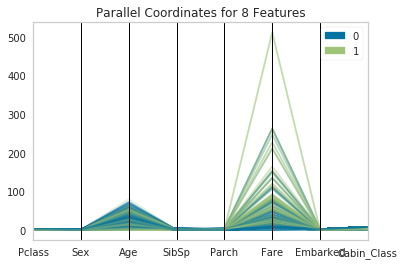

In [45]:
visualizer = ParallelCoordinates()
visualizer.fit_transform(X, y)
visualizer.poof()

# ParallelCoordinates

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_Class
0,3,1,22.0,1,0,7.2500,2,8
1,1,0,38.0,1,0,71.2833,0,2
2,3,0,26.0,0,0,7.9250,2,8
3,1,0,35.0,1,0,53.1000,2,2
4,3,1,35.0,0,0,8.0500,2,8
...,...,...,...,...,...,...,...,...
885,3,0,39.0,0,5,29.1250,1,8
886,2,1,27.0,0,0,13.0000,2,8
887,1,0,19.0,0,0,30.0000,2,1
889,1,1,26.0,0,0,30.0000,0,2


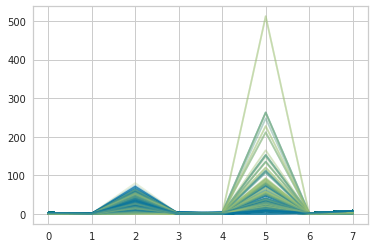

In [46]:
visualizer = ParallelCoordinates()
visualizer.fit_transform(X, y)

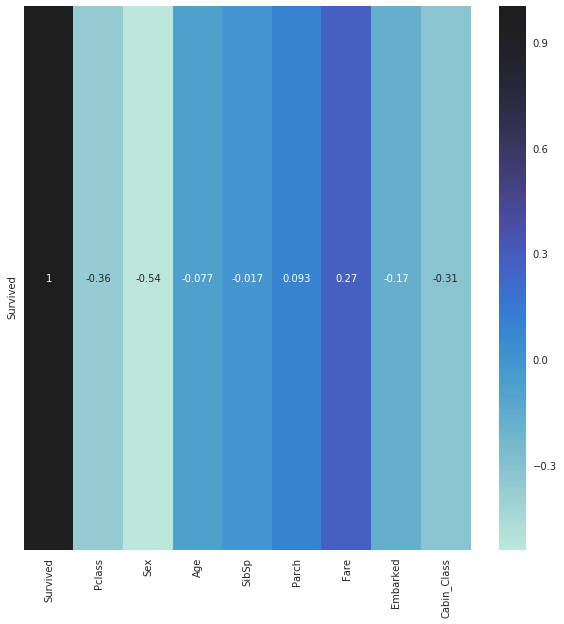

In [47]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corrwith(df['Survived']).values.reshape(1, -1), 
            xticklabels=df.columns,
            yticklabels=['Survived'],
           annot=True, center=True)

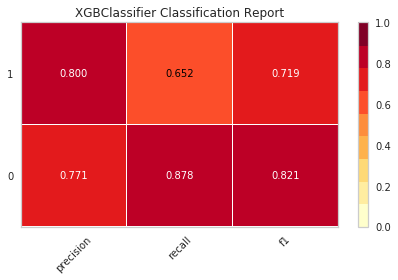

In [48]:
visualizer = ClassificationReport(model)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

In [49]:
from sklearn.metrics import confusion_matrix, classification_report

In [74]:
class CustomVisuals(object):
    
    def __init__(self, model, feature_names, classes):
        self.model = model
        self.feature_names = feature_names
        self.classes = classes
        
    def generate_classification_report(self, X_test, y_test, 
                                       zmin=0, zmax=1, annot=False, 
                                       **kwargs):
        """
        Given the test data sets, produces a classification report and returns a plotly
        Heatmap figure.
        
        :param X_test: The withheld input features from the training data set.
        :param y_test: The withheld output target from the training data set.
        :param zmin: (optional) sets scale minimum. Defaults to 0.
        :param zmax: (optional) sets scale maxmimum. Defaults to 1.
        """
        cr = classification_report(y_test, self.model.predict(X_test), output_dict=True)
        cr = pd.DataFrame(cr)
        
        fig_x = self.classes + ['accuracy', 'macro avg', 'weighted avg']
        fig_y = cr.index
        z_text = cr.values
        
        fig = go.Figure(
            go.Heatmap(
                z = cr.values,
                x = fig_x,
                y = fig_y,
                zmin = zmin if zmin is not None else zmin,
                zmax = zmax if zmax is not None else zmax,
                text = None if annot == False else z_text,
                **kwargs
            )
        )
        return fig
    def generate_confusion_matrix(self, X_test, y_test, **kwargs):
        """
        Given the test data sets, produces a confusion matrixs and returns a 
        plotly Heatmap figure.
        
        :param X_test: The withheld input features from the training data set.
        :param y_test: The withheld output target from the training data set.
        """
        
        cm = confusion_matrix(y_test, self.model.predict(X_test))
        
        fig_x = self.classes
        fig_y = self.classes
        fig_z = cm

        hovertext = list()
        for yi, yy in enumerate(fig_y):
            hovertext.append(list())
            for xi, xx in enumerate(fig_x):
                hovertext[-1].append(f'Predicted: {xx}<br />Actual: {yy}<br />Count: {fig_z[yi][xi]}')
      
        fig = go.Figure(
            go.Heatmap(
                z = fig_z, 
                x = fig_x,
                y = fig_y,
                hoverinfo='text',
                text=hovertext,
                **kwargs
            ),
            go.Layout(
                xaxis=go.layout.XAxis(
                    title=go.layout.xaxis.Title(text='Predicted', font=dict(size=24))
                ),
                yaxis=go.layout.YAxis(
                    title=go.layout.yaxis.Title(text='Actuals', font=dict(size=24))
                )
            
            )
        )
        return fig

In [75]:
cv = CustomVisuals(model=model, feature_names=X.columns, classes=['not_survived', 'survived'])

In [76]:
cv.generate_classification_report(X_test, y_test, colorscale='Viridis', annot=True)

## confusion matrix

In [77]:
cv.generate_confusion_matrix(X_test, y_test, colorscale='Viridis')

# Yellowbrick

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_Class
0,3,1,22.0,1,0,7.2500,2,8
1,1,0,38.0,1,0,71.2833,0,2
2,3,0,26.0,0,0,7.9250,2,8
3,1,0,35.0,1,0,53.1000,2,2
4,3,1,35.0,0,0,8.0500,2,8
...,...,...,...,...,...,...,...,...
885,3,0,39.0,0,5,29.1250,1,8
886,2,1,27.0,0,0,13.0000,2,8
887,1,0,19.0,0,0,30.0000,2,1
889,1,1,26.0,0,0,30.0000,0,2


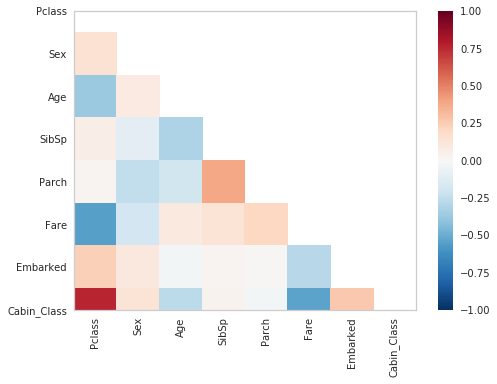

In [110]:
visualizer = Rank2D(algorithm='pearson')
visualizer.fit_transform(X)

In [123]:
## values
ranks_ = visualizer.ranks_

In [139]:
visualizer.ranking_methods

{'pearson': <function yellowbrick.features.rankd.Rank2D.<lambda>(X)>,
 'covariance': <function yellowbrick.features.rankd.Rank2D.<lambda>(X)>,
 'spearman': <function yellowbrick.features.rankd.Rank2D.<lambda>(X)>,
 'kendalltau': <function yellowbrick.features.rankd.Rank2D.<lambda>(X)>}

In [243]:
class YellowBrick(object):
    
    def __init__(self, model, feature_names, classes):
        self.model = model
        self.feature_names = feature_names
        self.classes = classes
       
    
    def generate_rank_2d(self, X, algorithm='pearson', **kwargs):
        """
        Given the entire (train+test) input features, returns a plotly
        Heatmap figure showing the feature x feature correlation.
        
        :param X: the input features to the model
        :param algorithm: the algorithm to calculate the importance with 
                          (pearson, covariance, spearman, kendalltau)
        """
        
        visualizer = Rank2D(algorithm=algorithm)
        visualizer.fit_transform(X)
        
        #grabbing feature shape
        feats = ranks_.shape[0]
        
        # zero-ing out one of the diagonals features
        iu = np.triu_indices(feats, )
        ranks_[iu] = -1
        
        fig = go.Figure(
            go.Heatmap(
                z = ranks_,
                x = visualizer.features_,
                y = np.flip(visualizer.features_), **kwargs
                
            )
        )
        
        return fig
    
    
    def generate_rank_1d(self, X, algorithm='shapiro', **kwargs):
        """
        Given the entire (train+test) input and target features, returns 
        a plotly figure showing the feature correlation.
        
        :param X: the input features to the model
        :param y: the target feature
        """
        
        visualizer = Rank1D(algorithm='shapiro')

        visualizer.fit(X, y)           # Fit the data to the visualizer
        visualizer.transform(X)        # Transform the data
        
        fig = go.Figure(
            go.Bar(
                x = visualizer.ranks_,
                y = visualizer.features_,
                orientation='h'
            )
        )
        
        return fig

In [244]:
yb = YellowBrick(model=model, feature_names=X.columns, classes=['not_survived', 'survived'])

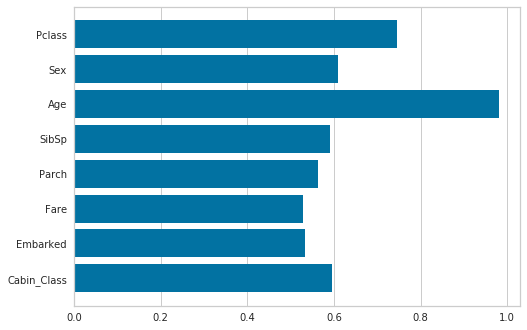

In [245]:
yb.generate_rank_1d(X, y)

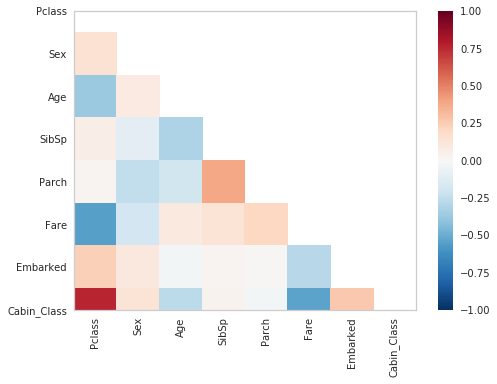

In [223]:
yb.generate_rank_2d(X)

In [59]:
# Specify the target classes
classes = ['not_survived', 'survived']

# Instantiate the visualizer
visualizer = RadViz(classes=classes, features=X.columns)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


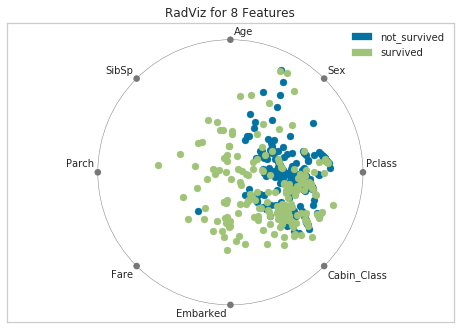

In [60]:
visualizer.fit(X_train, y_train)           # Fit the data to the visualizer
visualizer.transform(X_train)        # Transform the data
visualizer.poof()              # Draw/show/poof the data

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


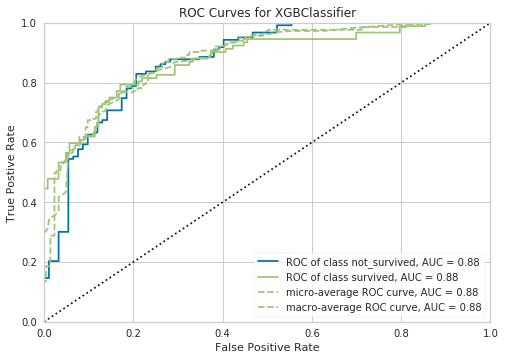

In [61]:
visualizer = ROCAUC(model, classes=['not_survived', 'survived'])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof()                       # Draw/show/poof the data


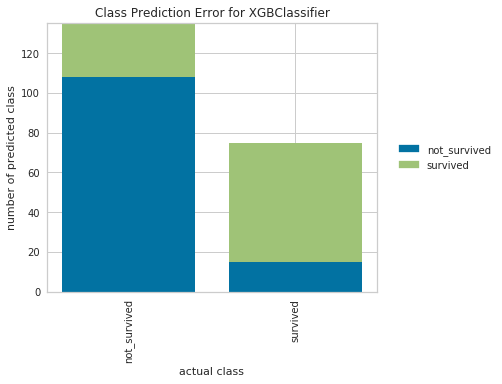

In [62]:
visualizer = ClassPredictionError(model=model, classes=classes)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.poof()

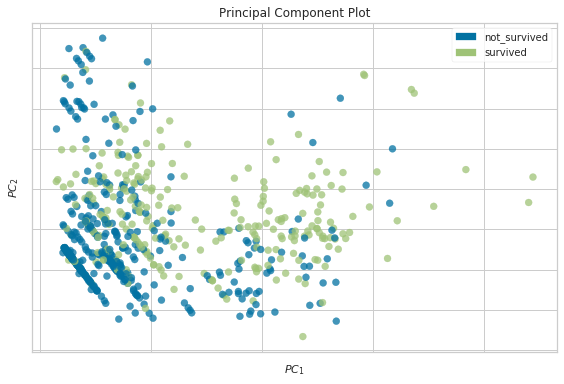

In [63]:

from yellowbrick.features.pca import PCADecomposition

# Create a list of colors to assign to points in the plot
colors = np.array(['r' if yi else 'b' for yi in y])

visualizer = PCADecomposition(scale=True, color=colors, classes=['not_survived', 'survived'])
visualizer.fit_transform(X, y)
visualizer.poof()